# Conditional querying and measure creation in Atoti  

Regardless of the programming language used, we always require conditional statements to manage things differently based on situations:

```
if value > x:
    do something
else:
    do different thing
```

To allow us manage our aggregation dynamically, [Atoti](https://www.atoti.io/) also has our own conditional functions:  
- [atoti.where](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html#atoti.where)
- [atoti.switch](https://docs.atoti.io/latest/lib/atoti/atoti.function.switch.html)
- [atoti.filter](https://docs.atoti.io/latest/lib/atoti/atoti.function.filter.html)  

Generally speaking, `atoti.where` and `atoti.switch` are implemented the same way and we can apply conditions on `measures` and `levels`.  
`atoti.filter`, on the other hand, is more restrictive as we can only apply conditions on `levels`. It is, however, faster in terms of performance.  

Other than defining measures conditionally, we can also query the atoti cube conditionally by using the `filter` parameter in `cube.query`. This would allow us to return a subset of the query results according to our needs.  
Keep on reading to see when and how we apply them in our queries and measure definition.  

__Note__: This notebook references the [XVA use case](https://github.com/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/risk-management/credit-risk/xva/main.ipynb) in the [Atoti CE notebook gallery](https://github.com/atoti/notebooks). Refer to the [app.py](./utils/app.py) for the details of the creation of cube, hierarchies and other measures created for this use case.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=conditions" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover+Atoti+now.jpg" alt="Try atoti"></a></div>

In [1]:
from utils import app

import atoti as tt

In [2]:
# set getDate="N" if you have previously downloaded data for this particular use case
session, cube = app.launch_cube(getData="Y")

Downloading: 100% [28237877 / 28237877] bytes


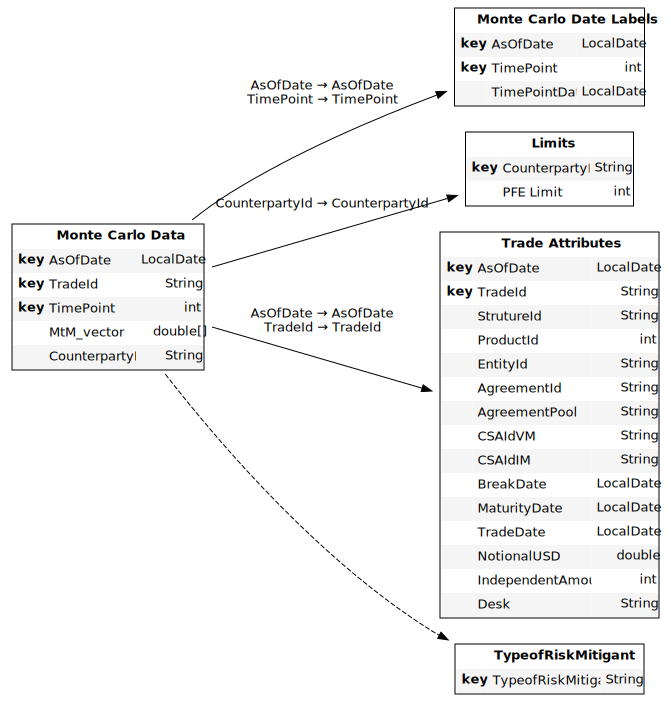

In [3]:
cube.schema

In [4]:
m, h, l = cube.measures, cube.hierarchies, cube.levels

## Querying atoti cube conditionally

We look at two ways we can query the Atoti cube:  
- [Visualization](https://activeviam.com/activeui/documentation/latest/docs/user-guides/filters) with the help to the Atoti JupyterLab extension or filter editor in the web application
- [Cube querying](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.query) that outputs a DataFrame

### Applying widget filter on data visualization

By applying widget filter on the below visualization, we restricted the view that is returned:  

<img src="img/visualization-filter.png" width="60%" />  

We excluded the "xVA Desk" and included only those `CounterpartyId` starting with "Banco".

In [5]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Using `filter` parameter in Cube Query

In the [`filter` parameter](https://docs.atoti.io/latest/lib/atoti-query/atoti_query.query_cube.html#atoti_query.QueryCube.query) of the `cube.query`, we can apply the conditions on levels to provide a subset of the returned result set. This is different from the [`atoti.filter` function](https://docs.atoti.io/latest/lib/atoti/atoti.function.filter.html) which we can use in measure definitions (shown below).  

Nonetheless, the way we write the conditions are similar. If there are more than one condition, remember to group each on in its on parenthesis before applying the logical operator in between. Use `&` for `and` operator, and `|` for `or` operator.  

__Note__: 
1. Filtering conditions in cube querying is inclusive only, i.e. we cannot negate `isin` to exclude `xVA Desk` as in the visualization above.  
2. The filter conditions for the query works only with _LevelCoordinates_ and not with _MeasureCoordinates_. This means, we cannot apply conditions such as `m["contributor.COUNT"] > 10` in the query. 
3. We can only apply __equality conditions__ on __constants__. i.e. `l["AsOfDate"] == "2020-09-08"` or `l["Desk"].isin("Commodities Desk", "Equity Desk", "Rates Desk")`.

In [6]:
cp_mtm_df = cube.query(
    m["MtM_vector.SUM"],
    levels=[l["Desk"], l["CounterpartyId"]],
    filter=(l["Desk"].isin("Commodities Desk", "Equity Desk", "Rates Desk"))
    & (
        l["CounterpartyId"].isin(
            "Banco Popular - Societa Cooperativa",
            "Banco Popular Espanol SA",
            "Banco Santander Chile (ADR)",
            "Banco Santander SA",
        )
    ),
)

cp_mtm_df.head()

MtM_vector.SUM
Desk             CounterpartyId                                                                        
Commodities Desk Banco Santander Chile (ADR)          [-115498.80719999998, 177260.41599999997, 8031...
                 Banco Santander SA                   [-60767.97259999999, 185600.36490000002, -1484...
Equity Desk      Banco Santander SA                   [-104984.0544, -38411.4983, -31112.7732, 14717...
Rates Desk       Banco Popular - Societa Cooperativa  [-136593.7919, 301989.33599999995, 182280.5862...

## Understanding `atoti.filter` function and its application

In this section, we look at the atoti function [`atoti.filter`](https://docs.atoti.io/latest/lib/atoti/atoti.function.filter.html#atoti.filter), which is different from the `filter` parameter of the `cube.query` function.  

We make use of the `atoti.filter` function in measure definitions to apply condition(s) on _levels_. It returns the measure value only when the condition is `True`. Otherwise, `None` is returned.  

In [7]:
from datetime import date

current_date = date.today()

In [8]:
m["Matured Notional Value"] = tt.filter(
    m["NotionalUSD"], l["MaturityDate"] <= current_date
)

In the above filter, we return the `NotionalUSD` values when `MaturityDate` is before or equal to current date.  
The `atoti.filter` function supports inequality comparisons.

In [9]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

We can also use `atoti.filter` if we want the measure to be returned for a particular member of the hierarchy only.  
E.g below, we compute the notional amount that is maturing in 2023.

In [10]:
m["Notional 2023"] = tt.filter(m["NotionalUSD"], l["Year"] == "2023")

In [11]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

To summarize, we make use of `atoti.filter` to return the values of a measure for either a given member of a level or a combination of selection criteria on multiple levels.  
Therefore, we __do not__ check for `None` type values using `atoti.filter`.

## Understanding `atoti.where` and its application

Different from `atoti.filter`, we can do the following with the [`atoti.where`](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html#atoti.where) function:
1. apply conditions on both _levels_ and _measures_
2. propose a different value for `atoti.where` when the condition returns false, i.e. the `else` option

Let's look at some examples.  

### Using conditional checks to hide grand totals

There are some instances where we do not want the sub-totals or grand-totals as it doesn't make sense to aggregate the values.

Let's take a quick look at the following Pivot table and suppose that we want the `CE_vector` value to be applicable only at the `TimePoint` level.  

In [12]:
cube.query(
    m["CE_vector"],
    levels=[
        l["CounterpartyId"],
        l["TimePoint"],
    ],
    filter=(l["CounterpartyId"] == "BOC Hong Kong (Holdings) Limited")
    & (l["TimePoint"].isin("0", "1", "2", "3", "4")),
    include_totals=True,
)

CE_vector
CounterpartyId                   TimePoint                                             
Total                                                doubleVector[1001]{4700.6671, ...}
BOC Hong Kong (Holdings) Limited                     doubleVector[1001]{4700.6671, ...}
                                 0          doubleVector[1001]{1447.2077000000002, ...}
                                 1          doubleVector[1001]{1228.1900999999998, ...}
                                 2                   doubleVector[1001]{1274.1402, ...}
                                 3           doubleVector[1001]{224.4532999999999, ...}
                                 4                    doubleVector[1001]{526.6758, ...}

In [13]:
m["CE"] = tt.where(~l["TimePoint"].isnull(), m["CE_vector"], None)

In the above measure definition, we returned the value of `CE_vector` only when `l["TimePoint"]` has a value.  
In the below query, there is no `TimePoint` value at the `CounterpartyId` level and above. Therefore, `CE_vector` is only returned up to the `TimePoint` level.  

__Note__: This is something that we cannot achieve with `atoti.filter` as it doesn't deal with `None` value.

In [14]:
cube.query(
    m["CE_vector"],
    m["CE"],
    levels=[
        l["CounterpartyId"],
        l["TimePoint"],
    ],
    filter=(l["CounterpartyId"] == "BOC Hong Kong (Holdings) Limited")
    & (l["TimePoint"].isin("0", "1", "2", "3", "4")),
    include_totals=True,
)

CE_vector  \
CounterpartyId                   TimePoint                                                
Total                                                doubleVector[1001]{4700.6671, ...}   
BOC Hong Kong (Holdings) Limited                     doubleVector[1001]{4700.6671, ...}   
                                 0          doubleVector[1001]{1447.2077000000002, ...}   
                                 1          doubleVector[1001]{1228.1900999999998, ...}   
                                 2                   doubleVector[1001]{1274.1402, ...}   
                                 3           doubleVector[1001]{224.4532999999999, ...}   
                                 4                    doubleVector[1001]{526.6758, ...}   

                                                                                     CE  
CounterpartyId                   TimePoint                                               
Total                                                                                    
BOC Hong Kong (Holdings) Limited                                                         
                                 0          doubleVector[1001]{1447.2077000000002, ...}  
                                 1          doubleVector[1001]{1228.1900999999998, ...}  
                                 2                   doubleVector[1001]{1274.1402, ...}  
                                 3           doubleVector[1001]{224.4532999999999, ...}  
                                 4                    doubleVector[1001]{526.6758, ...}

The above is a classic example of how we use `atoti.where` function:  
```
atoti.where(condition, true_value, false_value=None)
```

where `true_value` can be a __measure, measure definition, constant value or another `atoti.where` condition__ that is returned when condition is `true`.  
Similarly, `false_value` is the value returned when condition is `false`. It is defaulted to `None` when nothing is specified.  

### Comparing level against level

There are times when we would like to compare the members of two levels. For instance, to include the trade break dates into the exposure model as a risk mitigant, we take the `CE` value when the scenario date (`TimePointDate`) is before or on Trade break date (`BreakDate`). Otherwise, it is assumed that we exited the trade and `CE` is therefore `None`.  

In [15]:
m["Filtered MtM_vector.SUM"] = tt.where(
    l["TimePointDate"] <= l["BreakDate"], m["MtM_vector.SUM"]
)

m["CE with BreakDates"] = tt.agg.sum(
    tt.where(
        ~l["TimePoint"].isnull(),
        tt.array.positive_values(m["Filtered MtM_vector.SUM"]),
    ),
    scope=tt.OriginScope(l["BreakDate"], l["TimePointDate"]),
)

In [16]:
cube.query(
    m["CE with BreakDates"],
    m["contributors.COUNT"],
    levels=[
        l["CounterpartyId"],
        l["TimePoint"],
        l["TimePointDate"],
        l["BreakDate"],
    ],
    filter=(l["CounterpartyId"] == "BOC Hong Kong (Holdings) Limited")
    & (l["TimePoint"].isin("26", "28", "36", "43", "50")),
)

CE with BreakDates  \
CounterpartyId                   TimePoint TimePointDate BreakDate                                        
BOC Hong Kong (Holdings) Limited 26        2020-10-04    2020-10-06        doubleVector[1001]{0.0, ...}   
                                                         2029-09-20    doubleVector[1001]{1502.77, ...}   
                                 28        2020-10-06    2020-10-06        doubleVector[1001]{0.0, ...}   
                                                         2029-09-20  doubleVector[1001]{1608.0883, ...}   
                                 36        2020-10-14    2020-10-06                                       
                                                         2029-09-20   doubleVector[1001]{962.1073, ...}   
                                 43        2020-10-21    2020-10-06                                       
                                                         2029-09-20   doubleVector[1001]{682.4062, ...}   
                                 50        2020-10-28    2020-10-06                                       
                                                         2029-09-20   doubleVector[1001]{234.0055, ...}   

                                                                    contributors.COUNT  
CounterpartyId                   TimePoint TimePointDate BreakDate                      
BOC Hong Kong (Holdings) Limited 26        2020-10-04    2020-10-06                  1  
                                                         2029-09-20                  1  
                                 28        2020-10-06    2020-10-06                  1  
                                                         2029-09-20                  1  
                                 36        2020-10-14    2020-10-06                  1  
                                                         2029-09-20                  1  
                                 43        2020-10-21    2020-10-06                  1  
                                                         2029-09-20                  1  
                                 50        2020-10-28    2020-10-06                  1  
                                                         2029-09-20                  1

We can see that from time point 36 onwards, there is a breakdate with value and one without value for `CE with BreakDates` for each `TimePoint`.  
The `BreakDate` without values are those before the `TimePointDate` as per our conditions.  

## Assigning values conditionally to level members - `atoti.where` vs `atoti.switch`

Following the above Trade break date example, we will use the `atoti.where` condition to determine the [Expected exposure (EE)](https://www.bis.org/basel_framework/chapter/CRE/50.htm#:~:text=Expected%20exposure%20is%20the%20mean,transactions%20in%20the%20netting%20set.) based on the type of risk mitigant.

In [17]:
m["CE.MEAN"] = tt.array.mean(m["CE"])
m["CEBreakDate.MEAN"] = tt.array.mean(m["CE with BreakDates"])

m["EE (where)"] = tt.where(
    l["TypeofRiskMitigant"] == "No Risk Mitigant",
    m["CE.MEAN"],
    tt.where(
        l["TypeofRiskMitigant"] == "Trade Break Date",
        m["CEBreakDate.MEAN"],
    ),
)

In the above code snippet, we embedded:
1. another measure for the `true_value`
2. another `atoti.where` condition on the same level for the `false_value`.

We could embed even more `atoti.where` conditions as necessary but it will become a challenge in terms of readability.  
Below, we demonstrate how we could perform the same conditional assignment by using the [`atoti.switch` function](https://docs.atoti.io/latest/lib/atoti/atoti.function.switch.html#atoti.switch):

In [18]:
m["EE (switch)"] = tt.switch(
    l["TypeofRiskMitigant"],
    {
        "No Risk Mitigant": m["CE.MEAN"],
        "Trade Break Date": m["CEBreakDate.MEAN"],
    },
)

In [19]:
cube.query(
    m["CE.MEAN"],
    m["CEBreakDate.MEAN"],
    m["EE (where)"],
    m["EE (switch)"],
    levels=[
        l["CounterpartyId"],
        l["TimePoint"],
        l["TimePointDate"],
        l["BreakDate"],
        l["TypeofRiskMitigant"],
    ],
    filter=(l["CounterpartyId"] == "BOC Hong Kong (Holdings) Limited")
    & (l["TimePoint"].isin("26", "28", "36", "43", "50")),
)

CE.MEAN  \
CounterpartyId                   TimePoint TimePointDate BreakDate  TypeofRiskMitigant             
BOC Hong Kong (Holdings) Limited 26        2020-10-04    2020-10-06 No Risk Mitigant      478.44   
                                                                    Trade Break Date      478.44   
                                                         2029-09-20 No Risk Mitigant    3,211.21   
                                                                    Trade Break Date    3,211.21   
                                 28        2020-10-06    2020-10-06 No Risk Mitigant      511.16   
                                                                    Trade Break Date      511.16   
                                                         2029-09-20 No Risk Mitigant    3,214.52   
                                                                    Trade Break Date    3,214.52   
                                 36        2020-10-14    2020-10-06 No Risk Mitigant      536.18   
                                                                    Trade Break Date      536.18   
                                                         2029-09-20 No Risk Mitigant    3,242.34   
                                                                    Trade Break Date    3,242.34   
                                 43        2020-10-21    2020-10-06 No Risk Mitigant      558.82   
                                                                    Trade Break Date      558.82   
                                                         2029-09-20 No Risk Mitigant    3,258.21   
                                                                    Trade Break Date    3,258.21   
                                 50        2020-10-28    2020-10-06 No Risk Mitigant      570.81   
                                                                    Trade Break Date      570.81   
                                                         2029-09-20 No Risk Mitigant    3,261.56   
                                                                    Trade Break Date    3,261.56   

                                                                                       CEBreakDate.MEAN  \
CounterpartyId                   TimePoint TimePointDate BreakDate  TypeofRiskMitigant                    
BOC Hong Kong (Holdings) Limited 26        2020-10-04    2020-10-06 No Risk Mitigant             478.44   
                                                                    Trade Break Date             478.44   
                                                         2029-09-20 No Risk Mitigant           3,211.21   
                                                                    Trade Break Date           3,211.21   
                                 28        2020-10-06    2020-10-06 No Risk Mitigant             511.16   
                                                                    Trade Break Date             511.16   
                                                         2029-09-20 No Risk Mitigant           3,214.52   
                                                                    Trade Break Date           3,214.52   
                                 36        2020-10-14    2020-10-06 No Risk Mitigant                      
                                                                    Trade Break Date                      
                                                         2029-09-20 No Risk Mitigant           3,242.34   
                                                                    Trade Break Date           3,242.34   
                                 43        2020-10-21    2020-10-06 No Risk Mitigant                      
                                                                    Trade Break Date                      
                                                         2029-09-20 No Risk Mitigant           3,258.21   
                                                                    T

As we can see, both `atoti.where` and `atoti.switch` returns the same results. However, the code snippet for `atoti.switch` is more elegant and clean.  
Therefore, when you have multiple `else` conditions on the same level, do consider using `atoti.switch` for readability and easier coding. 

## When `atoti.where` behaves like a `atoti.switch`

`atoti.switch` apply conditional checks on members of a level. But what if you would like to have multiple conditions on a measure?  
Instead of having a `atoti.where` conditions that embeds multiple `atoti.where` conditions for the `else` situation, `atoti.where` can behave similar to `atoti.switch` for conditions on measures.

Coming back to our use case, we can impose limits monitoring using `atoti.where` conditions.  
Let's use the [Potential future exposure (PFE)](https://en.wikipedia.org/wiki/Potential_future_exposure) to see how it's done.  

In [20]:
m["PFE 1Y"] = tt.agg.sum(
    tt.filter(m["PFE"], l["TimePoint"] == 254),
    scope=tt.OriginScope(l["TimePoint"], l["CounterpartyId"]),
)

In [21]:
m["Breaches Status"] = tt.where(
    {
        m["PFE 1Y"] > m["PFE Limit"]: "🟥",
        m["PFE 1Y"] == m["PFE Limit"]: "🔶",
        m["PFE 1Y"] < m["PFE Limit"]: "🟢",
    }
)

In [22]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Last but not least

<img src="img/summary.png"/>  

Check out the above summary table for a quick reference on how the conditional function works. Refer to the [Atoti CE documentation](https://docs.atoti.io/) for details of the functions. As always, we love to hear from you. Share with us on [GitHub Discussions](https://github.com/atoti/atoti/discussions) if we are missing out on how you expects the conditional statements should work.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=conditions" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>